In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import choice, seed
from joblib import Parallel, delayed
from sklearn.linear_model import LogisticRegression

### Load Data

In [2]:
matches = pd.read_csv(r'../data/kotd6/matches.csv')
matches['Patch'] = 'New'
matches.loc[matches['Round']=='R64','Patch'] = 'Old'
matches['APMDiff'] = matches.eval('WinnerAPM-LoserAPM')

seeding = pd.read_csv(r'../data/kotd6/seeding.csv')
seeding['Seed'] = 1
seeding['Seed'] = seeding['Seed'].cumsum()

matches = pd.merge(matches, seeding.rename(columns={'Player':'Winner', 'TournamentElo':'WinnerElo', 'Seed':'WinnerSeed'}),
                   on='Winner', how='inner')
matches = pd.merge(matches, seeding.rename(columns={'Player':'Loser', 'TournamentElo':'LoserElo', 'Seed':'LoserSeed'}),
                   on='Loser', how='inner')
matches['WinnerIsFave'] = matches.eval('WinnerSeed<LoserSeed').astype(int)
matches['EloDifference'] = matches.eval('WinnerElo-LoserElo')

civRanking = pd.read_csv(r'../processed/kotd6/civRanking.csv')
civRanking_r64 = pd.read_csv(r'../processed/kotd6/civRanking_r64.csv')
civRanking['Patch'] = 'New'
civRanking_r64['Patch'] = 'Old'

civRankingJoiner = pd.concat([civRanking, civRanking_r64])[['Patch', 'Civs', 'Rank']]

matches = pd.merge(matches, civRankingJoiner.rename(columns={'Civs':'WinnerCiv', 'Rank':'WinnerCivRank'}),
         on=['Patch', 'WinnerCiv'], how='inner')
matches = pd.merge(matches, civRankingJoiner.rename(columns={'Civs':'LoserCiv', 'Rank':'LoserCivRank'}),
         on=['Patch', 'LoserCiv'], how='inner')
matches['WinnerCivIsFave'] = matches.eval('WinnerCivRank<LoserCivRank').astype(int)
matches['LoserCivIsFave'] = matches.eval('LoserCivRank<WinnerCivRank').astype(int)

drafts = pd.read_parquet(r'../processed/kotd6/drafts.parquet')
drafts['ID'] = ['_'.join(sorted(tpl)) for tpl in zip(drafts.Host,drafts.Guest)]
drafts.set_index('ID', inplace=True)

winnerCivPickNum = []
loserCivPickNum = []
for _,row in matches.iterrows():
    ID = '_'.join(sorted([row['Winner'], row['Loser']]))
    localDraft = drafts.loc[ID]
    winnerKey = 'HostPick' if (row['Winner']==localDraft['Host']) else 'GuestPick'
    loserKey = 'GuestPick' if winnerKey=='HostPick' else 'HostPick'
    winnerCivPickNum.append(1+list(localDraft[winnerKey]).index(row['WinnerCiv']))
    loserCivPickNum.append(1+list(localDraft[loserKey]).index(row['LoserCiv']))
    
matches['WinnerCivPickNum'] = winnerCivPickNum
matches['LoserCivPickNum'] = loserCivPickNum
matches['WinnerBetterCivPickNum'] = matches.eval('WinnerCivPickNum<LoserCivPickNum').astype(int)
matches['LoserBetterCivPickNum'] = matches.eval('LoserCivPickNum<WinnerCivPickNum').astype(int)

In [3]:
# any null values in data?
matches.isnull().any().any()

False

### Basic Distributions

In [4]:
# how many games had laming?
matches.eval('WinnerLamedBoar+WinnerGotBoarLamed>=1').mean()*100

9.426229508196721

In [5]:
# how many games won by favourite by seed?
matches.groupby('WinnerIsFave')['Round'].count().pipe(lambda x: x*100/sum(x))

WinnerIsFave
0    25.0
1    75.0
Name: Round, dtype: float64

In [6]:
# how many games won by favourite by tournament elo?
matches.groupby(matches.EloDifference>0)['Round'].count().pipe(lambda x: x*100/sum(x))

EloDifference
False    26.229508
True     73.770492
Name: Round, dtype: float64

In [7]:
# how many games won by player with better map?
matches.groupby('WinnerBetterMap')['Round'].count().pipe(lambda x: x*100/sum(x))

WinnerBetterMap
0    65.163934
1    34.836066
Name: Round, dtype: float64

In [8]:
# how many games won by better civ?
matches.groupby('WinnerCivIsFave')['Round'].count().pipe(lambda x: x*100/sum(x))

WinnerCivIsFave
0    48.770492
1    51.229508
Name: Round, dtype: float64

In [9]:
# how many games won by an earlier civ pick?
matches.groupby('WinnerBetterCivPickNum')['Round'].count().pipe(lambda x: x*100/sum(x))

WinnerBetterCivPickNum
0    59.836066
1    40.163934
Name: Round, dtype: float64

### APM Distributions

In [10]:
apmDiff = matches.eval('WinnerAPM-LoserAPM').abs().sort_values().reset_index()
apmDiff['index'] = 1
apmDiff['index'] = apmDiff['index'].cumsum()
apmDiff['index'] = apmDiff['index']*100/apmDiff['index'].max()

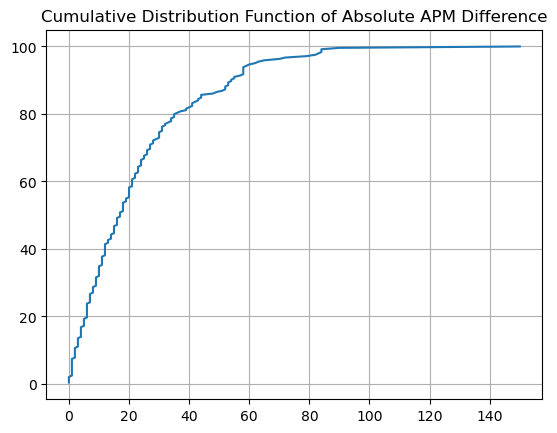

In [11]:
apmDiff.set_index(0)['index'].plot()
plt.xlabel('')
plt.title('Cumulative Distribution Function of Absolute APM Difference')
plt.grid()

In [12]:
l = []
for idx in range(50,90,5):
    l.append(apmDiff[apmDiff['index']<=idx].iloc[[-1]])
apmDiffExtract = pd.concat(l)
apmDiffExtract

,index,0
121,50.000000,17
133,54.918033,19
145,59.836066,21
157,64.754098,24
169,69.672131,27
182,75.000000,31
194,79.918033,35
206,84.836066,44


In [13]:
apmThres = 17
matches['WinnerMoreAPM'] = matches.eval(f'(WinnerAPM-LoserAPM)>={apmThres}').astype(int)
matches['LoserMoreAPM'] = matches.eval(f'(LoserAPM-WinnerAPM)>={apmThres}').astype(int)

In [14]:
# how many games won by player with significantly more APM?
matches.groupby('WinnerMoreAPM')['Round'].count().pipe(lambda x: x*100/sum(x))

WinnerMoreAPM
0    67.213115
1    32.786885
Name: Round, dtype: float64

### Correlation

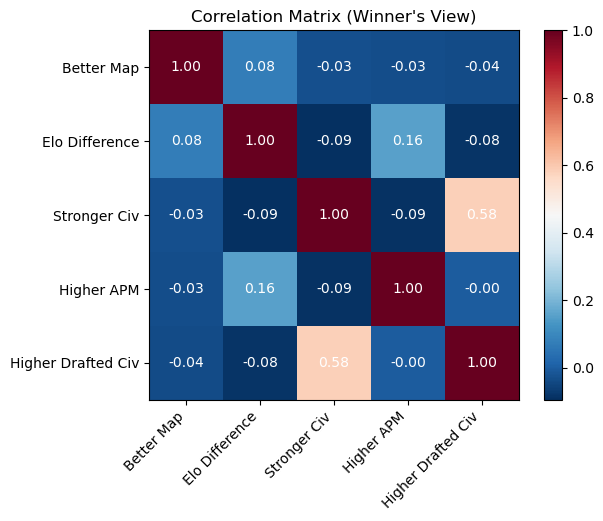

In [15]:
corr = matches[['WinnerBetterMap', 'EloDifference', 'WinnerCivIsFave', 'WinnerMoreAPM', 'WinnerBetterCivPickNum']].corr()
corrMap = {'WinnerBetterMap':'Better Map', 'EloDifference':'Elo Difference', 'WinnerCivIsFave':'Stronger Civ',
          'WinnerMoreAPM':'Higher APM', 'WinnerBetterCivPickNum':'Higher Drafted Civ'}
ax=plt.imshow(corr, cmap='RdBu_r')
plt.colorbar()
plt.xticks(range(len(corr)), [corrMap[x] for x in corr.columns], rotation=45, ha='right')
plt.yticks(range(len(corr)), [corrMap[x] for x in corr.index])

for i,col in enumerate(corr.columns):
    for j,idx in enumerate(corr.columns):
        plt.text(j, i, f'{corr[col][idx]:.2f}', ha='center', va='center', color="w")
        
_ = plt.title("Correlation Matrix (Winner's View)")

### Logistic Regression

In [16]:
def inverseLogit(x):
    return np.exp(x)/(1+np.exp(x))

In [17]:
coefs = []
predictors = ['TargetPlayerBetterMap', 'TargetPlayerEloDiff', 'TargetCivIsFave', 'TargetPlayerMoreAPM', 
              'TargetPlayerBetterCivNum']

def getCoefs(inp, pCols, C=np.inf):
    lr = LogisticRegression(penalty='l1', C=C, solver='saga')    
    lr.fit(inp[pCols], inp['TargetPlayerWon'])    
    baseline = inverseLogit(lr.intercept_[0])
    individual = inverseLogit((lr.intercept_+lr.coef_)[0])   
    return [baseline]+list(individual-baseline)

def getMatrixForRegression(inp, s, apmThres):
    ret = inp.copy()
    seed(s)
    ret['TargetPlayer'] = [choice(['Winner', 'Loser']) for _ in range(len(ret))]
    ret['TargetPlayerWon'] = ret.TargetPlayer.replace({'Winner':1, 'Loser':0})
    
    # Normalize elo difference into units of 100
    ret['TargetPlayerEloDiff'] = ret['EloDifference']/100
    ret.loc[ret.TargetPlayer=='Loser','TargetPlayerEloDiff'] *= -1
    
    ret['TargetCivIsFave'] = ret['WinnerCivIsFave']    
    ret.loc[ret.TargetPlayer=='Loser','TargetCivIsFave'] = ret['LoserCivIsFave']
        
    ret['TargetPlayerBetterMap'] = ret['WinnerBetterMap']
    ret.loc[ret.TargetPlayer=='Loser','TargetPlayerBetterMap'] = ret['LoserBetterMap']
        
    ret['WinnerMoreAPM'] = ret.eval(f'(WinnerAPM-LoserAPM)>={apmThres}').astype(int)
    ret['LoserMoreAPM'] = ret.eval(f'(LoserAPM-WinnerAPM)>={apmThres}').astype(int)
    ret['TargetPlayerMoreAPM'] = ret['WinnerMoreAPM']
    ret.loc[ret.TargetPlayer=='Loser','TargetPlayerMoreAPM'] = ret['LoserMoreAPM']
    
    ret['TargetPlayerBetterCivNum'] = ret['WinnerBetterCivPickNum']
    ret.loc[ret.TargetPlayer=='Loser','TargetPlayerBetterCivNum'] = ret['LoserBetterCivPickNum']
    
    return ret[predictors+['TargetPlayerWon']].copy() 

def worker(s, apmThres, C=np.inf):
    matrix = getMatrixForRegression(matches, s, apmThres)
    ret = getCoefs(matrix, predictors, C)
    return [apmThres, C]+ret
    
res = pd.DataFrame.from_records(
    Parallel(n_jobs=20, verbose=1)(delayed(worker)(s, apmThres
                                                  ) for s in range(1000) for apmThres in apmDiffExtract[0]),
    columns=['APMThres', 'RegularizationStrength', 'Baseline']+predictors)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    6.7s
[Parallel(n_jobs=20)]: Done 248 tasks      | elapsed:    8.3s
[Parallel(n_jobs=20)]: Done 1200 tasks      | elapsed:   11.6s
[Parallel(n_jobs=20)]: Done 2600 tasks      | elapsed:   15.2s
[Parallel(n_jobs=20)]: Done 4400 tasks      | elapsed:   19.7s
[Parallel(n_jobs=20)]: Done 6600 tasks      | elapsed:   25.4s
[Parallel(n_jobs=20)]: Done 8000 out of 8000 | elapsed:   28.9s finished


In [18]:
predictorMap = {'TargetPlayerBetterMap':'Better Map', 'TargetPlayerEloDiff':'100 Elo Difference',
                'TargetCivIsFave':'Stronger Civ', 'TargetPlayerMoreAPM':'Higher APM', 
                'TargetPlayerBetterCivNum':'Higher Drafted Civ'}

def makePlot(predList, coefVals):
    ax = plt.subplot(1,1,1)
    summary = coefVals.drop(columns=['APMThres', 'RegularizationStrength']).describe()
    print(summary)
    for p in predList:
        coefM = summary[p]['mean']*100
        coefStd = summary[p]['std']*100
        lbl = f'{predictorMap[p]} ({coefM:.1f} \u00B1 {coefStd:.1f}%)'
        (100*coefVals[p]).plot.hist(bins=50, ax=ax, density=True, alpha=0.5, label=lbl)
    plt.legend(bbox_to_anchor=(1,1))
    plt.xlim(-15,20)
    plt.axvline(0, color='black', alpha=0.4)
    plt.xlabel('Incremental Win Rate Contribution')
    plt.ylabel('')
    ax.set_yticklabels([])
    plt.title('Incremental Contribution of Different Factors to Arabia Win Rate')
    plt.grid()

          Baseline  TargetPlayerBetterMap  TargetPlayerEloDiff  \
count  1000.000000            1000.000000          1000.000000   
mean      0.421249               0.080408             0.161138   
std       0.041742               0.045167             0.003208   
min       0.279981              -0.091530             0.149581   
25%       0.393026               0.050073             0.159201   
50%       0.421038               0.080175             0.161130   
75%       0.448670               0.111117             0.162954   
max       0.563514               0.209478             0.177451   

       TargetCivIsFave  TargetPlayerMoreAPM  TargetPlayerBetterCivNum  
count      1000.000000          1000.000000               1000.000000  
mean          0.114786             0.062045                 -0.039416  
std           0.027264             0.056360                  0.043439  
min           0.020460            -0.154189                 -0.177183  
25%           0.096102             0.025747  

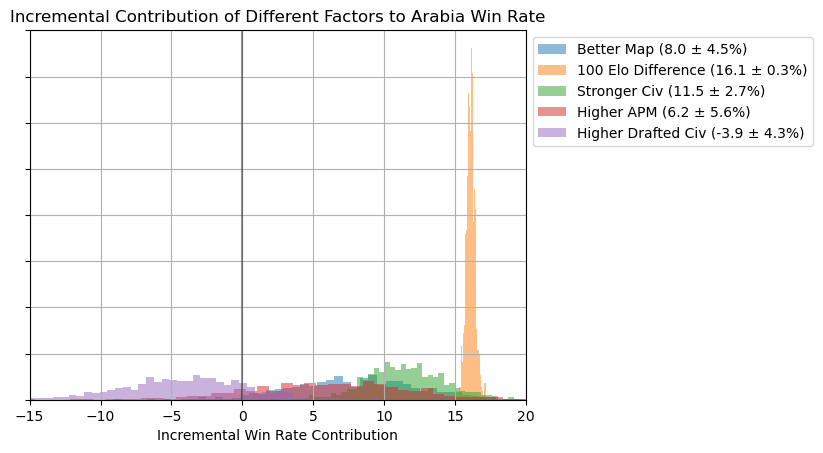

In [19]:
### Use the minimum APM threshold (corresponding to median abs diff of APMs across matches)
makePlot(predictors, res.query('APMThres==APMThres.min()'))

### Check Sensitivity to APM Threshold

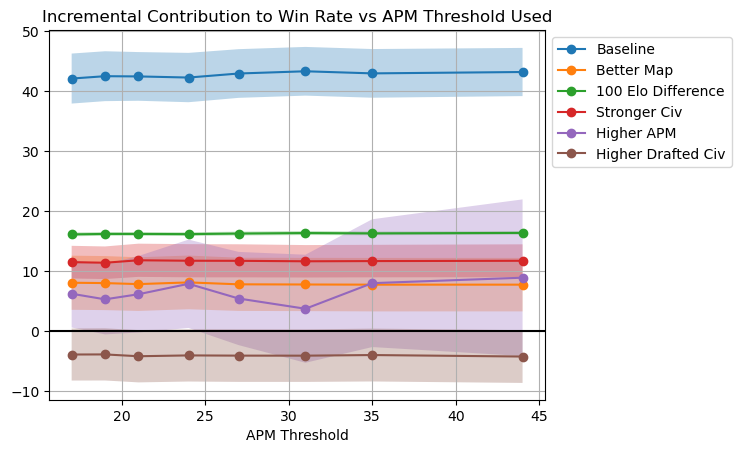

In [20]:
for c in res.columns:
    if c in ('APMThres', 'RegularizationStrength'):
        continue
    coefByApm = 100*res.groupby('APMThres')[c].mean()
    coefStd = 100*res.groupby('APMThres')[c].std()
    lower = coefByApm-coefStd
    upper = coefByApm+coefStd
    
    plt.plot(coefByApm.index, coefByApm.values, marker='o', label=predictorMap.get(c,c))
    plt.fill_between(coefByApm.index, lower, upper, alpha=0.3)
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('APM Threshold')
plt.title('Incremental Contribution to Win Rate vs APM Threshold Used')
plt.axhline(0, color='black')
plt.grid()

### L1 Regularization

In [21]:
mult = pow(10, -0.25)
Cs = [1]
for i in range(8):
    Cs.append(Cs[-1]*mult)

resL1 = pd.DataFrame.from_records(
    Parallel(n_jobs=20, verbose=1)(delayed(worker)(s, apmDiffExtract[0].iloc[0], C
                                                  ) for s in range(1000) for C in Cs ),
    columns=['APMThres', 'RegularizationStrength', 'Baseline']+predictors)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.6s
[Parallel(n_jobs=20)]: Done 2600 tasks      | elapsed:    6.4s
[Parallel(n_jobs=20)]: Done 5400 tasks      | elapsed:   13.3s
[Parallel(n_jobs=20)]: Done 8860 tasks      | elapsed:   21.6s
[Parallel(n_jobs=20)]: Done 9000 out of 9000 | elapsed:   21.9s finished


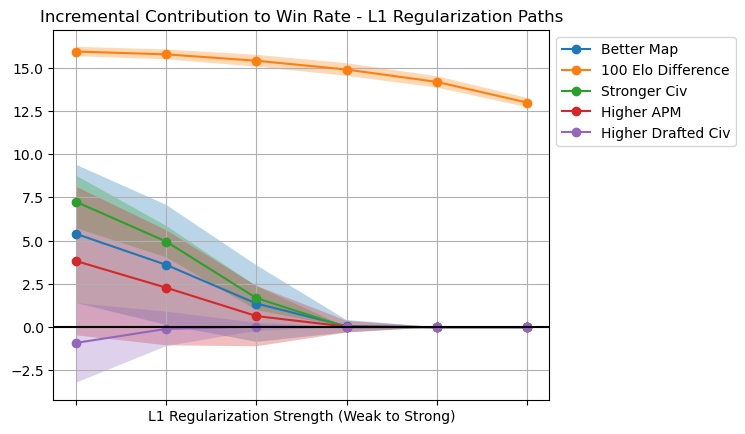

In [22]:
for c in resL1.columns:
    if c in ('APMThres', 'RegularizationStrength', 'Baseline'):
        continue
    coefReg = 100*resL1.groupby('RegularizationStrength')[c].mean().iloc[-6:]
    coefStd = 100*resL1.groupby('RegularizationStrength')[c].std().iloc[-6:]
    lower = coefReg-coefStd
    upper = coefReg+coefStd
    
    idx = list(range(len(coefReg), 0, -1))
    plt.plot(idx, coefReg.values, marker='o', label=predictorMap.get(c,c))
    plt.fill_between(idx, lower, upper, alpha=0.3)
plt.legend(bbox_to_anchor=(1,1))
plt.tick_params(axis='x', labelbottom=False)
plt.xlabel('L1 Regularization Strength (Weak to Strong)')
plt.title('Incremental Contribution to Win Rate - L1 Regularization Paths')
plt.axhline(0, color='black')
plt.grid()